# How to compute currents, voltage and torque using the Electrical Module

This tutorial explains how to use the Electrical Module to compute currents, voltage and torque, using a simple **electrical equivalent circuit**. The idea is to provide insight on how to implement other methods.

The reference used to validate this tutorial is: Z. Yang, M. Krishnamurthy and I. P. Brown, "Electromagnetic and vibrational characteristic of IPM over full torque-speed range," 2013 International Electric Machines & Drives Conference, Chicago, IL, 2013, pp. 295-302, doi: 10.1109/IEMDC.2013.6556267.

## Machine and Simulation definition
This tutorial use the machine IPMSM_A (Prius 2004) defined in the "[How to define a machine](https://pyleecan.org/tuto_Machine.html)" tutorial. The configuration is similar to the one used in the "[How to set the Operating Point](https://pyleecan.org/tuto_Operating_point.html)" tutorial.

Pyleecan version:1.1.0


<IPython.core.display.Javascript object>


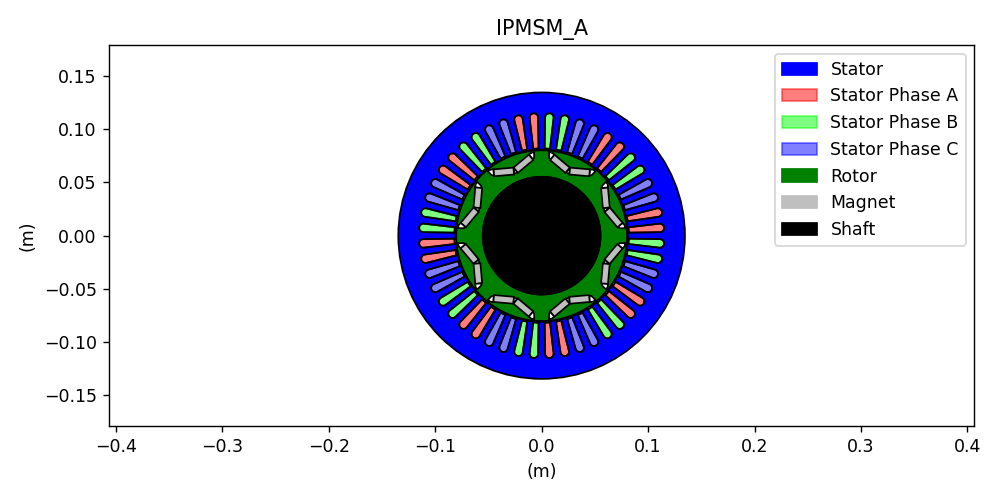

In [1]:
%matplotlib notebook

import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
# Load the machine
from os.path import join
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR

IPMSM_A = load(join(DATA_DIR, "Machine", "IPMSM_A.json"))
IPMSM_A.plot()

## Electrical Equivalent Circuit (EEC)
The electrical module is defined with the object EEC_PMSM that correspond to the **electrical equivalent circuit** from "Advanced Electrical Drives, analysis, modeling, control", Rik de doncker, Duco W.J. Pulle, Andre Veltman, Springer edition, is then used for the computation of Ud/Uq or Id/Iq (see schematics hereafter). 

The parameters from the EEC are first computed according to the `FluxLinkFEMM` and `IndMagFEMM` objects. They enable to compute the flux linkage and the magnetic inductances using FEMM simulations (with symmetries and number of time steps). For the flux linkage computation, the currents are set to 0A.

Once the parameter of the EEC known, the voltage can be computed. The electrical torque is then computed according to the formula: $T_{em}=\frac{P-RI^2}{\Omega}$, where $P$ is the magnetic power $P=\frac{q_s}{2}\Re(VI^*)$

                 <---                               --->
     -----R-----wsLqIq----              -----R-----wsLdId----
    |                     |            |                     |
    |                     |            |                    BEMF
    |                     |            |                     |
     ---------Id----------              ---------Iq----------
             
             --->                               ---> 
              Ud                                 Uq

In [13]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.Electrical import Electrical
from pyleecan.Classes.EEC_PMSM import EEC_PMSM
from pyleecan.Classes.FluxLinkFEMM import FluxLinkFEMM
from pyleecan.Classes.IndMagFEMM import IndMagFEMM

# Initialization of the Simulation
simu = Simu1(name="tuto_elec", machine=IPMSM_A)

# Definition of the magnetic simulation (FEMM with symmetry and sliding band)
simu.elec = Electrical(
    eec=EEC_PMSM(
        indmag=IndMagFEMM(is_periodicity_a=True, Nt_tot=50),
        fluxlink=FluxLinkFEMM(is_periodicity_a=True, Nt_tot=50),
    )
)
# Run only Electrical module
simu.mag = None
simu.force = None
simu.struct = None

## Defining starting point with InputElec or InputCurrent

The starting point of the simulation is defined with InputElec or InputCurrent. These objects will create an "OutElec" object and initialize it with the provided values for Id/Iq, and/or Ud/Uq with InputElec. InputCurrent enables to define in several ways the starting point (see "[How to set the Operating Point](https://pyleecan.org/tuto_Machine.html)").

Note that Id/Iq are required to accurately compute the magnetic inductances, so that if only Ud/Uq is provided, a current Id=1A and Iq=1A will be used for the computation of Ld and Lq. A more satisfactory method would be to compute a map of Ld and Lq over Id/Iq. Future developments would be welcomed.

In [14]:
from pyleecan.Classes.InputCurrent import InputCurrent
from numpy import sqrt, exp, pi

# Definition of a sinusoidal current
simu.input = InputCurrent()

I0_rms = 250/sqrt(2) # Maximum current [Arms]
Phi0 = 140*pi/180  # Maximum Torque Per Amp

Id_ref = (I0_rms*exp(1j*Phi0)).real
Iq_ref = (I0_rms*exp(1j*Phi0)).imag

simu.input.Id_ref = Id_ref # [Arms] 
simu.input.Iq_ref = Iq_ref # [Arms] 

simu.input.Nt_tot = 50 # Number of time steps
simu.input.Na_tot = 2048 # Spatial discretization
simu.input.N0 = 2000 # Rotor speed [rpm]

(Id_ref,Iq_ref)

(-135.4188051049254, 113.62986941801093)

## Running the simulation and postprocessings

In [15]:
out = simu.run()

[14:56:20] Starting running simulation tuto_elec (machine=IPMSM_A)
[14:56:20] Starting Electric module
[14:56:20] INFO: Compute flux linkage with FEMM
[14:57:32] INFO: Compute dq inductances with FEMM
[14:58:34] End of simulation tuto_elec


In [16]:
# Print voltage and torque
print("Ud: "+str(out.elec.Ud_ref))
print("Uq: "+str(out.elec.Uq_ref))
print("Tem: "+str(out.elec.Tem_av_ref))

Ud: -201.2378050091584
Uq: -12.666035512466053
Tem: 353.6393920916952


<IPython.core.display.Javascript object>


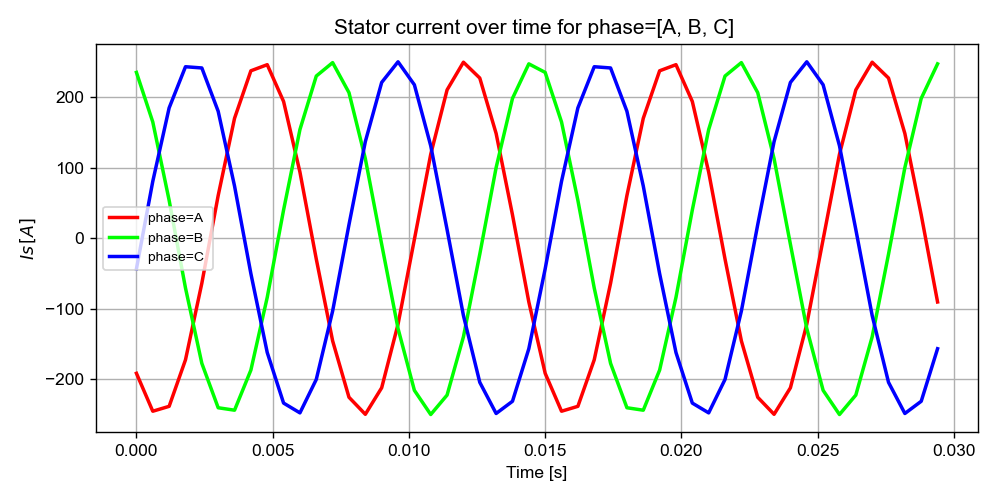

In [17]:
from pyleecan.Functions.Plot import dict_2D
# Plot the currents
out.elec.get_Is().plot_2D_Data("time", "phase", **dict_2D)

<IPython.core.display.Javascript object>


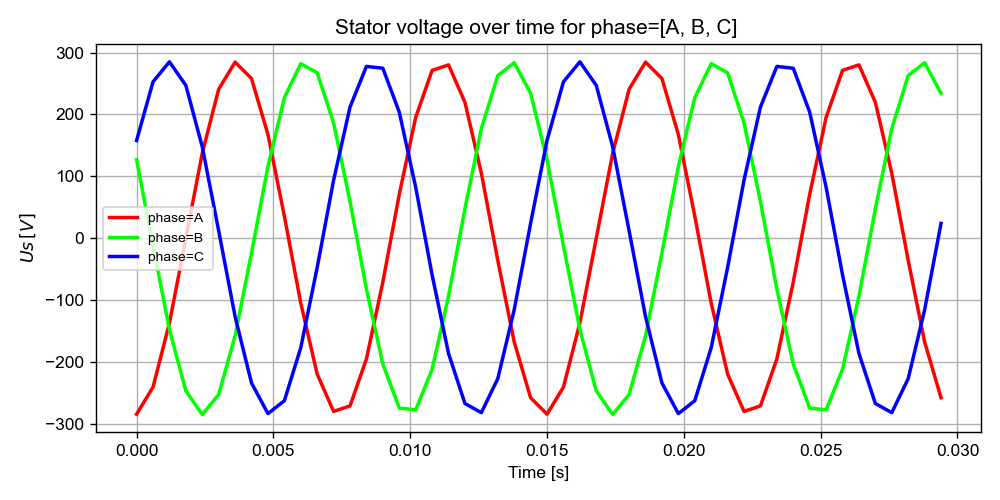

In [18]:
# Plot the voltages
out.elec.Us.plot_2D_Data("time", "phase", **dict_2D)

## Iterating on several Operating Points
Reference torque and current angle vector are:

In [19]:
from numpy import linspace, array, pi
Tem_av_ref = array([79, 125, 160, 192, 237, 281, 319, 343, 353, 332, 266, 164, 22]) # Yang et al, 2013
Phi0_ref = linspace(60 * pi / 180, 180 * pi / 180, Tem_av_ref.size)
N_simu = Tem_av_ref.size

The multisimulation is similar to the one described in "[How to set the Operating Point](https://pyleecan.org/tuto_Machine.html)", except that we are now computing the electrical torque instead of the magnetic torque.

In [20]:
from pyleecan.Classes.VarLoadCurrent import VarLoadCurrent
from numpy import zeros, ones, linspace, array, sqrt, arange

varload = VarLoadCurrent(is_torque=True)
varload.type_OP_matrix = 0 # Matrix N0, I0, Phi0

# Creating the Operating point matrix
OP_matrix = zeros((N_simu,4))

# Set N0 = 2000 [rpm] for all simulation
OP_matrix[:,0] = 2000 * ones((N_simu))

# Set I0 = 250 / sqrt(2) [A] (RMS) for all simulation
OP_matrix[:,1] = I0_rms * ones((N_simu)) 

# Set Phi0 from 60° to 180°
OP_matrix[:,2] = Phi0_ref

# Set reference torque from Yang et al, 2013
OP_matrix[:,3] = Tem_av_ref

varload.OP_matrix = OP_matrix
print(OP_matrix)

[[2.00000000e+03 1.76776695e+02 1.04719755e+00 7.90000000e+01]
 [2.00000000e+03 1.76776695e+02 1.22173048e+00 1.25000000e+02]
 [2.00000000e+03 1.76776695e+02 1.39626340e+00 1.60000000e+02]
 [2.00000000e+03 1.76776695e+02 1.57079633e+00 1.92000000e+02]
 [2.00000000e+03 1.76776695e+02 1.74532925e+00 2.37000000e+02]
 [2.00000000e+03 1.76776695e+02 1.91986218e+00 2.81000000e+02]
 [2.00000000e+03 1.76776695e+02 2.09439510e+00 3.19000000e+02]
 [2.00000000e+03 1.76776695e+02 2.26892803e+00 3.43000000e+02]
 [2.00000000e+03 1.76776695e+02 2.44346095e+00 3.53000000e+02]
 [2.00000000e+03 1.76776695e+02 2.61799388e+00 3.32000000e+02]
 [2.00000000e+03 1.76776695e+02 2.79252680e+00 2.66000000e+02]
 [2.00000000e+03 1.76776695e+02 2.96705973e+00 1.64000000e+02]
 [2.00000000e+03 1.76776695e+02 3.14159265e+00 2.20000000e+01]]


In [21]:
# Run multisimulation
simu2 = simu.copy()
simu2.var_simu = varload
Xout = simu2.run()

[15:00:16] Starting running simulation tuto_elec (machine=IPMSM_A)
[15:00:16] Reference Operating point is not in OP_matrix, one extra simulation will be computed
[15:00:16] Computing reference simulation for Variable Load
[15:00:16] Starting Electric module
[15:00:16] Variable Load Reference Results: N0=2000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], I0=176.8 [A], Phi0=2.443 [], Tem_av_ref=353.6 [N.m]
[===                                               ]   7%
[15:00:16] Running simulation 1/13 with N0=2000 [rpm], Id=88.39 [Arms], Iq=153.1 [Arms]
[15:00:16] Starting Electric module
[15:00:16] INFO: Compute dq inductances with FEMM
[15:01:13] Variable Load Results: N0=2000 [rpm], Id=88.39 [Arms], Iq=153.1 [Arms], I0=176.8 [A], Phi0=1.047 [], Tem_av_ref=81.83 [N.m]
[=======                                           ]  14%
[15:01:13] Running simulation 2/13 with N0=2000 [rpm], Id=60.46 [Arms], Iq=166.1 [Arms]
[15:01:13] Starting Electric module
[15:01:13] INFO: Compute dq inductances with F

Once the simulation is done, the torque as a function of Phi0 can be plotted with:

<IPython.core.display.Javascript object>


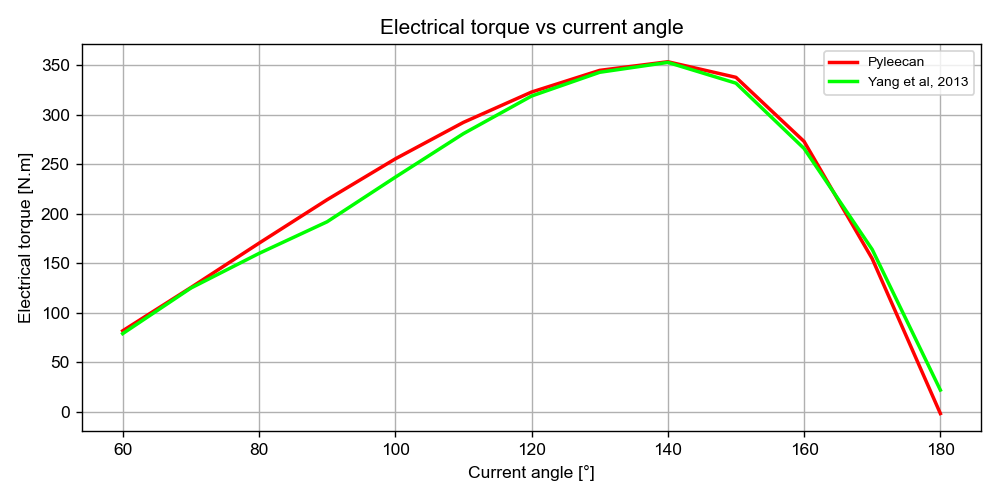

In [23]:
# Plot torque as a function of Phi0
from SciDataTool.Functions.Plot.plot_2D import plot_2D
from numpy import array

plot_2D(
    array([x*180/pi for x in Xout.xoutput_dict["Phi0"].result]),
    [Xout.xoutput_dict["Tem_av_ref"].result, Tem_av_ref],
    legend_list=["Pyleecan", "Yang et al, 2013"],
    xlabel="Current angle [°]",
    ylabel="Electrical torque [N.m]",
    title="Electrical torque vs current angle",
    **dict_2D
)